In [31]:
%%script false --no-raise-error
%%bash
pip install numpy
pip install pandas
pip install matplotlib==3.7.0
pip install tikzplotlib
pip install scipy

In [32]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from scipy.optimize import curve_fit

from pathlib import Path

In [33]:
from packaging.version import Version
if Version(matplotlib.__version__) > Version('3.7.0'):
    raise RuntimeWarning('tikzplotlib cant work with matplotlib > 3.7')

import tikzplotlib
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [34]:
ROOT_PATH = Path('./..')

LATEX_PATH = ROOT_PATH / 'paper'

RESOURCES_PATH = ROOT_PATH / 'resources'

CPP_BUILD_PATH = ROOT_PATH / 'build'

# Расходно напорная характеристика

In [35]:
# initials
P = np.array([2808.80274448953, 2964.84734140562, 2902.42950263918, 2715.17598633988, 2496.71355065736, 2325.06449404967, 2059.78867929232, 1279.5656947119, 592.969468281124])
Q = np.array([0, 5.58329944639905, 11.1665988927981, 16.7498983391972, 22.3331977855962, 25.1248475087957, 27.9164972319952, 33.4997966783943, 37.9664362355135])

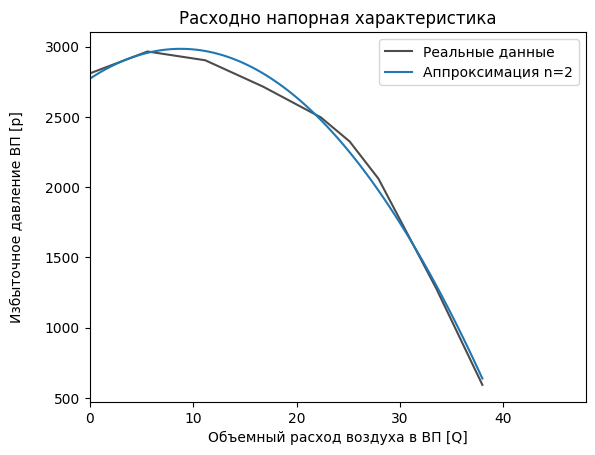

In [36]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(Q, P, 'k', label='Реальные данные', alpha=0.7)

_z = np.polyfit(Q, P, 2)
_p = np.poly1d(_z)
_dp = _p.deriv()
_xp = np.linspace(Q.min(), Q.max(), 100)
ax.plot(_xp, _p(_xp), label=f'Аппроксимация n={2}')

ax.set_xlabel('Объемный расход воздуха в ВП [Q]')
ax.set_ylabel('Избыточное давление ВП [p]', labelpad=15)
ax.set_xlim(Q.min(), Q.max() + 10)
plt.title('Расходно напорная характеристика')
plt.legend()
plt.plot();

# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save(LATEX_PATH / 'graph_tikz.tex')


In [37]:
print('Квадратичная функция: ', _p, sep='\n')
A, B, C = _p.coefficients
q_max = 8.791162734091653
print('Вершина параболы:', -B / 2 / A)
print('Максимальное давление:', _p(q_max))

Квадратичная функция: 
        2
-2.756 x + 48.46 x + 2771
Вершина параболы: 8.791162734091653
Максимальное давление: 2983.8648146802116


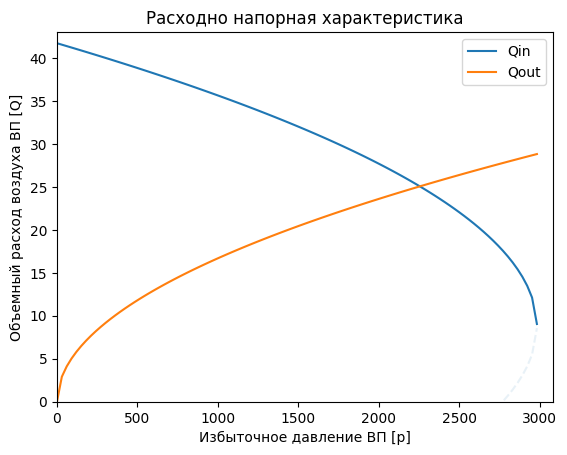

In [38]:
def Qin(p: float, right=True) -> float:
    A = -2.756
    B = 48.46
    C = 2771

    D = B * B - 4 * A * (C - p)
    if right:
        return (-B - np.sqrt(D)) / 2 / A
    return (-B + np.sqrt(D)) / 2 / A


def Qout(p: float) -> float:
    Sgap = 0.42
    rho = 1.269
    chi = 1
    return chi * np.sqrt(2 * p / rho) * Sgap


def maxP() -> float:
    Qtop = -B / 2 / A
    lo = 0.0
    hi = A * Qtop * Qtop + B * Qtop + C
    return hi


fig, ax = plt.subplots()
_xp = np.linspace(0, maxP(), 100, endpoint=True)
ax.plot(_xp, Qin(_xp), label='Qin')
ax.plot(_xp, Qin(_xp, right=False), 'C0--', alpha=0.1)
ax.plot(_xp, Qout(_xp), label='Qout')
# ax.plot(_xp, Qin(_xp) - Qout(_xp), label='Qin - Qout')
ax.set_xlim(0, maxP() + 100)
ax.set_ylim(0, 43)
ax.set_ylabel('Объемный расход воздуха ВП [Q]')
ax.set_xlabel('Избыточное давление ВП [p]')
plt.title('Расходно напорная характеристика')
plt.legend()
plt.plot();

# tikzplotlib_fix_ncols(fig)
# tikzplotlib.save(LATEX_PATH / 'graph2_tikz.tex')

## Коэффициент демпфирования

In [39]:
# initials
D = np.array([2483720.930232558, 2218604.6511627906, 2002325.5813953488, 1756395.3488372092, 1533139.5348837208, 1311627.906976744, 1065697.6744186047, 868604.6511627907, 488372.0930232558, 279069.76744186046, 174418.60465116278, 129069.76744186046, 94186.04651162791, 75000, 61046.51162790698, 43604.651162790695, 33139.53488372093, 31395.3488372093, 26162.79069767442, 24418.60465116279, 15697.67441860465, 8720.93023255814, 8720.93023255814, 6976.7441860465115])
S_gap_S = np.array([0.0009855072463768116, 0.0011207729468599033, 0.0012463768115942029, 0.001391304347826087, 0.0015169082125603866, 0.001681159420289855, 0.0018743961352657005, 0.002038647342995169, 0.0024057971014492755, 0.0030144927536231883, 0.004048309178743961, 0.004801932367149759, 0.005603864734299517, 0.006338164251207729, 0.007246376811594203, 0.008367149758454106, 0.009536231884057972, 0.010743961352657004, 0.01182608695652174, 0.012937198067632851, 0.014309178743961353, 0.01592270531400966, 0.017072463768115942, 0.018309178743961353])

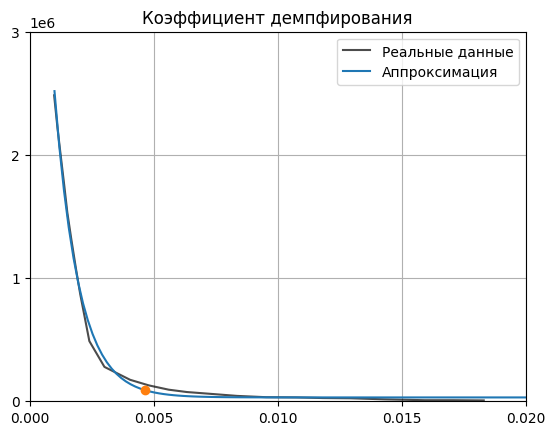

In [40]:
def f(x, a, b, c):
    return a + b * np.exp(-c * x)


fig, ax = plt.subplots()
ax.plot(S_gap_S, D, 'k', label='Реальные данные', alpha=0.7)

popt, _ = curve_fit(f, S_gap_S, D, bounds=(0, np.inf), method='trf')
_xp = np.linspace(0.001, 0.02, 100, endpoint=True)
ax.plot(_xp, f(_xp, *popt), label=f'Аппроксимация')

ax.plot(0.004667, f(0.004667, *popt), 'o')

ax.set_xlim(0, 0.02)
ax.set_xticks([0, 0.005, 0.01, 0.015, 0.02])
ax.set_ylim(0, 3e6)
ax.set_yticks([0, 1e6, 2e6, 3e6])
plt.title('Коэффициент демпфирования')
plt.legend()
plt.legend(loc='best')
plt.grid(True)
plt.plot();

In [41]:
print('Экспоненциальная функция:')
print(f'{popt[0]} + {popt[1]} * np.exp({popt[2]} * x)')

Экспоненциальная функция:
31253.553067256977 + 6930673.352075487 * np.exp(1025.1778568097657 * x)


## Визуализация состояний системы

In [42]:
SIMULATION_DT = 1e-5

df = pd.read_csv(RESOURCES_PATH / 'sim_6.csv', delimiter=';')
df['dt'] = df.index * SIMULATION_DT
df.head(10)

,H,W,phi,p,Q_in,Q_out,dH/dt,p_qs,p_damp,S_gap,S,dt
0,0.71,63.9,0,1742.40,30.0186,22.0082,0.000000,1742.40,0.000000e+00,0.42,90,0.00000
1,0.71,63.9,0,1742.57,30.0171,22.0093,0.000987,1742.57,0.000000e+00,0.42,90,0.00001
2,0.71,63.9,0,1742.75,30.0156,22.0105,0.001974,1742.75,-3.354170e-07,0.42,90,0.00002
3,0.71,63.9,0,1742.92,30.0141,22.0116,0.002772,1742.92,-1.006090e-06,0.42,90,0.00003
4,0.71,63.9,0,1743.10,30.0126,22.0127,0.003381,1743.10,-1.947770e-06,0.42,90,0.00004
5,0.71,63.9,0,1743.27,30.0111,22.0138,0.003837,1743.27,-3.096230e-06,0.42,90,0.00005
6,0.71,63.9,0,1743.45,30.0096,22.0149,0.004177,1743.45,-4.399550e-06,0.42,90,0.00006
7,0.71,63.9,0,1743.62,30.0081,22.0160,0.004429,1743.62,-5.818090e-06,0.42,90,0.00007
8,0.71,63.9,0,1743.80,30.0066,22.0171,0.004616,1743.80,-7.322130e-06,0.42,90,0.00008
9,0.71,63.9,0,1743.97,30.0051,22.0182,0.004754,1743.97,-8.889550e-06,0.42,90,0.00009


In [43]:
test_df = df.drop(columns=['H', 'W', 'phi', 'Q_out', 'dt'])
test_df['S_gap / S'] = test_df['S_gap'] / test_df['S']
test_df['D(S_gap / S)'] = f(test_df['S_gap / S'], *popt)
test_df['Q_in / dH/dt'] = test_df['Q_in'] / test_df['dH/dt']
test_df.head(10)

,p,Q_in,dH/dt,p_qs,p_damp,S_gap,S,S_gap / S,D(S_gap / S),Q_in / dH/dt
0,1742.40,30.0186,0.000000,1742.40,0.000000e+00,0.42,90,0.004667,89201.719019,inf
1,1742.57,30.0171,0.000987,1742.57,0.000000e+00,0.42,90,0.004667,89201.719019,3.040645e+04
2,1742.75,30.0156,0.001974,1742.75,-3.354170e-07,0.42,90,0.004667,89201.719019,1.520493e+04
3,1742.92,30.0141,0.002772,1742.92,-1.006090e-06,0.42,90,0.004667,89201.719019,1.082779e+04
4,1743.10,30.0126,0.003381,1743.10,-1.947770e-06,0.42,90,0.004667,89201.719019,8.877025e+03
5,1743.27,30.0111,0.003837,1743.27,-3.096230e-06,0.42,90,0.004667,89201.719019,7.821216e+03
6,1743.45,30.0096,0.004177,1743.45,-4.399550e-06,0.42,90,0.004667,89201.719019,7.184968e+03
7,1743.62,30.0081,0.004429,1743.62,-5.818090e-06,0.42,90,0.004667,89201.719019,6.775566e+03
8,1743.80,30.0066,0.004616,1743.80,-7.322130e-06,0.42,90,0.004667,89201.719019,6.500718e+03
9,1743.97,30.0051,0.004754,1743.97,-8.889550e-06,0.42,90,0.004667,89201.719019,6.310898e+03


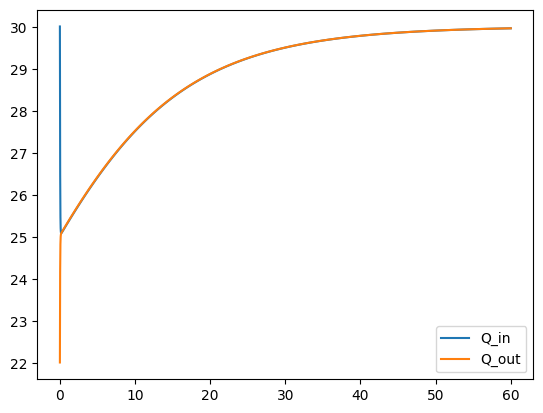

In [44]:
fig, ax = plt.subplots()
ax.plot(df['dt'], df['Q_in'], label='Q_in')
ax.plot(df['dt'], df['Q_out'], label='Q_out')
plt.legend()
plt.plot();

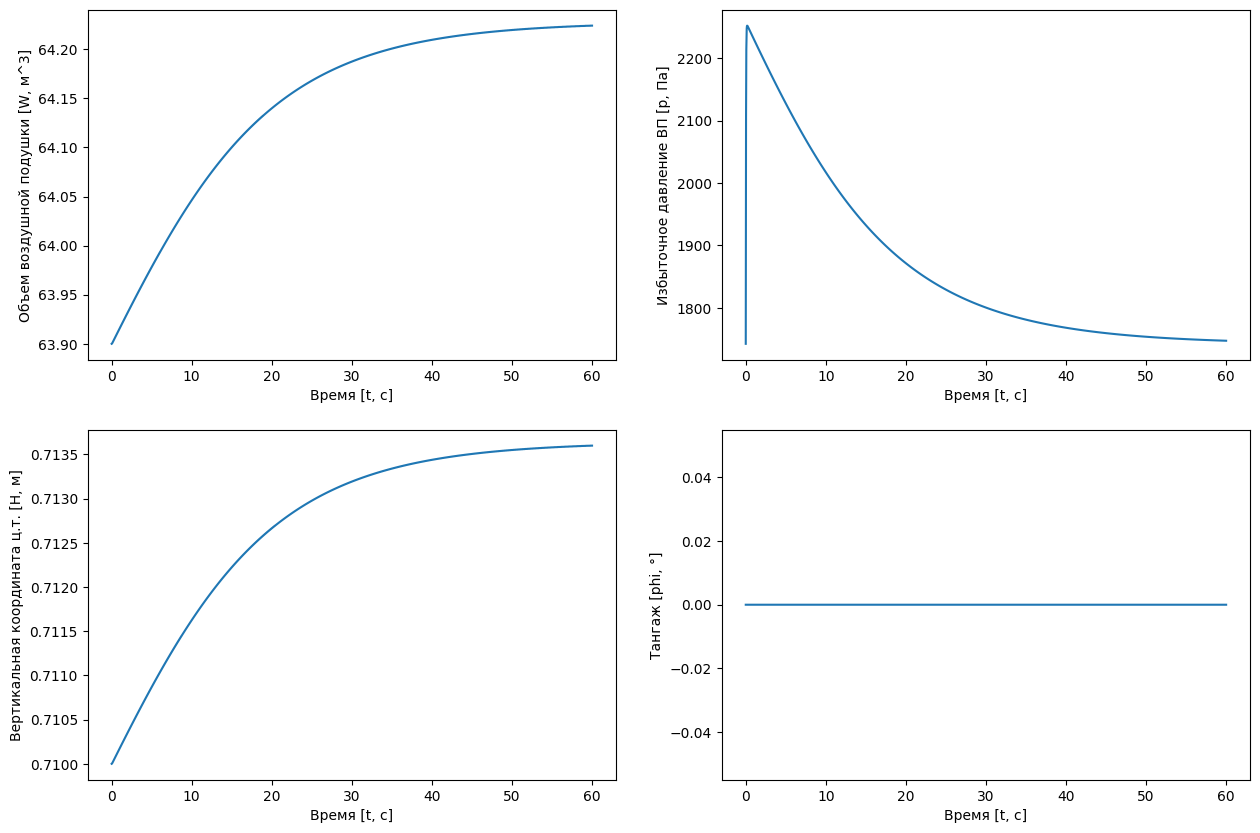

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(df['dt'], df['W'])
ax1.set_ylabel('Объем воздушной подушки [W, м^3]')
ax1.set_xlabel('Время [t, с]')

ax2.plot(df['dt'], df['p'])
ax2.set_ylabel('Избыточное давление ВП [p, Па]')
ax2.set_xlabel('Время [t, с]')

ax3.plot(df['dt'], df['H'])
ax3.set_ylabel('Вертикальная координата ц.т. [H, м]')
ax3.set_xlabel('Время [t, с]')

ax4.plot(df['dt'], list(map(math.degrees, df['phi'])))
ax4.set_ylabel('Тангаж [phi, °]')
ax4.set_xlabel('Время [t, с]')

plt.plot();

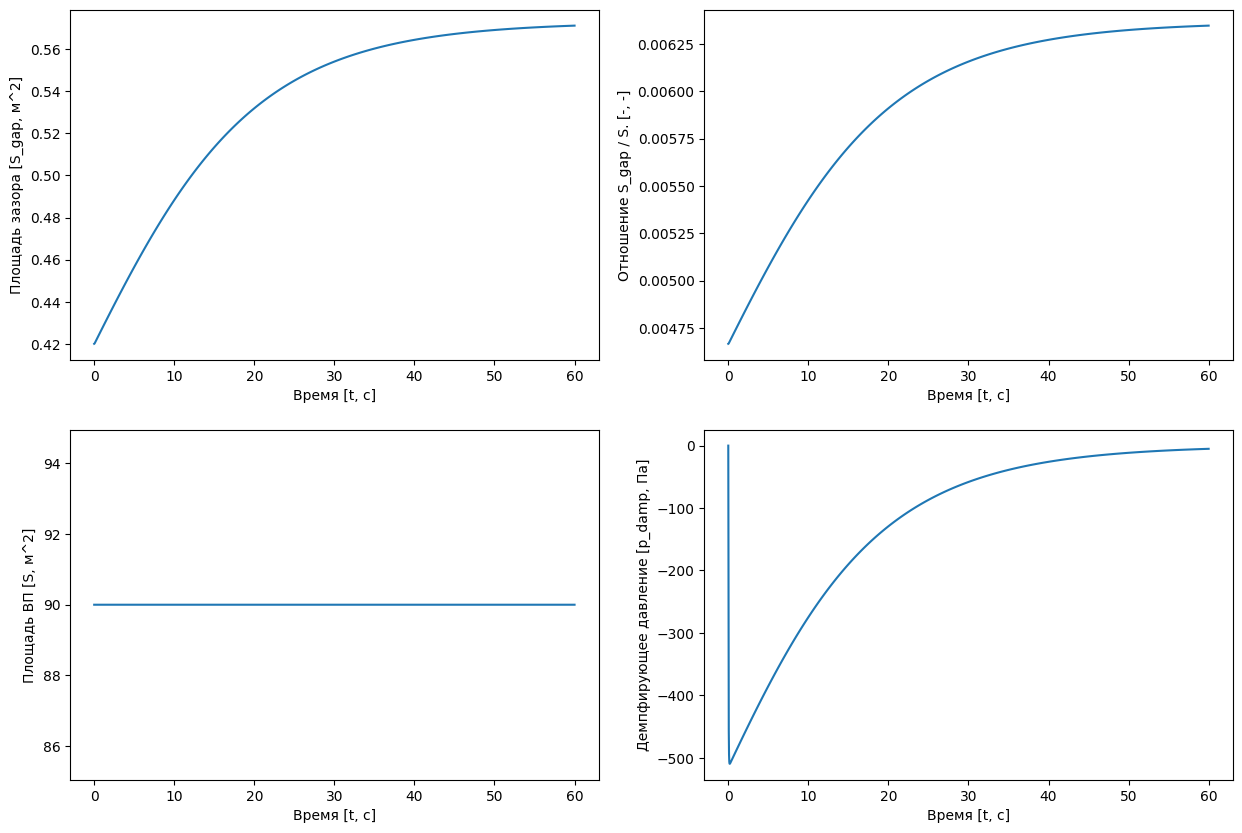

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(df['dt'], df['S_gap'])
ax1.set_ylabel('Площадь зазора [S_gap, м^2]')
ax1.set_xlabel('Время [t, с]')

ax2.plot(df['dt'], df['S_gap'] / df['S'])
ax2.set_ylabel('Отношение S_gap / S. [-, -]')
ax2.set_xlabel('Время [t, с]')

ax3.plot(df['dt'], df['S'])
ax3.set_ylabel('Площадь ВП [S, м^2]')
ax3.set_xlabel('Время [t, с]')

ax4.plot(df['dt'], df['p_damp'] / SIMULATION_DT)
ax4.set_ylabel('Демпфирующее давление [p_damp, Па]')
ax4.set_xlabel('Время [t, с]')

plt.plot();